# TAL Research
## **EDA: Part 2 of 4** - Processing Data into Train and Test



**Objective**: Develop a small scale model based on the data provided to appropriately help the team prioritize accounts for our sales reps to target.

**What we know**:
- **unique ID** is the id_number, i.e. every id number belongs to a unique company. This is important because it determines how we will consider (concatenate) the different datasets (excel files) with each other.

**Datasets**:
- **Account Base File**: List of all accounts with unique id (id_number) and some additional basic account/firmographic data.
- **Email Action File**: Denotes email clicks or replies and the date
- **Intent File**: Includes categories of affiliate sites visited by the account and the date of the action, with a categorized bucket for the type of affiliate site interest.
- **Engagement File**: Includes campaign engagement and website visit data, along with the date the action occurred.
- **Third Party Readiness Score File**: Includes an account readiness score acquired via a third party data provider.
- **Met Target Date File**: A list of Accounts that met the target (i.e. reached participated in a trial with our company), and the date the target was met.




# Dataset preparation for **training**
## Note: The given separate datasets cannot be used as is for modelling.

I will put together (concatenate) the datasets according per unique ID (i.e. company).

This however is not enough, we will have a lot of missing data, because each of these datasets have not been collected for every single company. See previous file 1-eda for each dataset EDA.

This means that I will:
- merge per ID
- consider only the companies that have met the target
- consider also the companies that have had an interaction
- the total will be 565 companies, out of which 316 have converted

This will results in 565 companies considered for the training dataset, out of which 316 have met target:
- This data will be used to train our model. 
- In this dataset we will perform the typical train/validation/test splits and our modelling choices. 
- From here we will draw insights, trends and patterns.

Consequently, there will be a separate dataset of 2463 companies that are not considered for our training dataset at all. This will serve as our 'untouched' ultimate testing dataset. It is on these that I will provide suggestions and evaluations. 

#### Imports

In [41]:
import pandas as pd
import seaborn as sns
import sys
import os
from matplotlib import pyplot as plt

In [42]:
# Determine the directory of the current notebook/script
current_dir = os.getcwd()

# Define the path to the src directory
src_dir = os.path.join(current_dir, '..', '..')

# Add the src directory to the system path
sys.path.append(src_dir)

# Now you can import the load_data function from utils
try:
    from utils import load_excel_data
    print("Import successful!")
except ModuleNotFoundError as e:
    print("Error importing utils:", e)

Import successful!


In [43]:
datasets = ["Accounts_Data_Final", 
            "EmailAction", 
            "Engagement_Data", 
            "Intent", 
            "TargetMet_Date", 
            "ThirdPartyReadinessScore"]

In [44]:
# Load all datasets
data_accounts = load_excel_data(datasets[0])
data_email = load_excel_data(datasets[1])
data_engagement = load_excel_data(datasets[2])
data_intent = load_excel_data(datasets[3])
data_target_met = load_excel_data(datasets[4])
data_third_party = load_excel_data(datasets[5])

####  1. Account Base File
**Account Base File**: List of all accounts with unique id (id_number) and some additional
basic account/firmographic data.

In [45]:
data_accounts.head()

,org_size_1_99,org_size_100_499,org_size_500_999,org_size_1000_4999,org_size_greaterthan_5000,Post_Sale_Outreach,Has_Website,PreviousCompetitorCustomer,Number_of_Vehicles__c,Segment_E,SegmentE3,SegmentA1,SegmentA2,US_Country,CA_Country,Industry,billingstatecode
id_number,,,,,,,,,,,,,,,,,
76,0,0,0,0,0,1,1,Y,17.0,0,0,0,1,1,0,WholesaleTrade,SC
120,0,0,1,0,0,1,1,Y,50.0,0,1,0,0,1,0,WholesaleTrade,MO
127,1,0,0,0,0,1,1,N,50.0,0,0,0,1,0,1,WholesaleTrade,ON
156,0,0,0,0,0,1,1,N,2200.0,1,0,0,0,1,0,WholesaleTrade,VA
182,0,0,0,0,0,1,1,N,64.0,0,0,0,1,1,0,WholesaleTrade,IN


In [46]:
print(f"There are {len(data_accounts.index.unique())} unique identifiers in the data, which here means unique accounts.")


There are 3028 unique identifiers in the data, which here means unique accounts.


#### 2. Email Action File

**Email Action File**: Denotes email clicks or replies and the date


In [47]:
data_email = pd.read_excel('../../../data/DS_Homework_-_EmailAction.xlsx', parse_dates=['action_date'], header=1, index_col=0)
data_email

,action_date,action_count,action_type
id_number,,,
285,2024-02-01 18:45:26+00:00,1,click
2796,2023-01-17 16:57:55+00:00,1,reply
312,2022-06-01 15:36:29+00:00,1,reply
258,2021-12-02 17:24:34+00:00,1,reply
2225,2022-01-31 16:26:42+00:00,1,click
...,...,...,...
2917,2023-05-19 19:24:29+00:00,1,reply
118,2021-08-23 19:01:28+00:00,1,click
2745,2023-09-25 12:56:20+00:00,1,click


**Feature Engineering**

In [48]:
import pandas as pd

# Load your data into a pandas DataFrame from an Excel file
data_email = pd.read_excel('../../../data/DS_Homework_-_EmailAction.xlsx', parse_dates=['action_date'], header=1, index_col=0)

# Ensure the data is sorted by company and date
data_email = data_email.sort_values(by=['id_number', 'action_date'])

# Create lag features
lags = [1, 2, 5, 7]
for lag in lags:
    data_email[f'action_count_lag_{lag}'] = data_email.groupby('id_number')['action_count'].shift(lag)

# Create rolling averages
rolling_window = 7
data_email['action_count_rolling_avg_7'] = data_email.groupby('id_number')['action_count'].rolling(window=rolling_window).mean().reset_index(level=0, drop=True)

# Time-Based Features
data_email['action_year'] = data_email['action_date'].dt.year
data_email['action_month'] = data_email['action_date'].dt.month
data_email['action_day'] = data_email['action_date'].dt.day
data_email['action_dayofweek'] = data_email['action_date'].dt.dayofweek
data_email['action_hour'] = data_email['action_date'].dt.hour

# Interaction Rate Features
data_email['weekly_interaction_rate'] = data_email.groupby('id_number')['action_count'].rolling(window=7).sum().reset_index(level=0, drop=True) / 7

# Previous Action Type
data_email['previous_action_type'] = data_email.groupby('id_number')['action_type'].shift(1)

# Cumulative Counts
data_email['cumulative_action_count'] = data_email.groupby('id_number')['action_count'].cumsum()
data_email['cumulative_click_count'] = data_email.groupby('id_number')['action_type'].apply(lambda x: (x == 'click').cumsum()).reset_index(level=0, drop=True)
data_email['cumulative_reply_count'] = data_email.groupby('id_number')['action_type'].apply(lambda x: (x == 'reply').cumsum()).reset_index(level=0, drop=True)

# Days Since Last Action
data_email['days_since_last_action'] = data_email.groupby('id_number')['action_date'].diff().dt.days

# Rolling Window Statistics
data_email['rolling_std_7'] = data_email.groupby('id_number')['action_count'].rolling(window=7).std().reset_index(level=0, drop=True)
data_email['rolling_median_7'] = data_email.groupby('id_number')['action_count'].rolling(window=7).median().reset_index(level=0, drop=True)

# Calculate the average time between interactions for each id_number
data_email['time_between_interactions'] = data_email.groupby('id_number')['action_date'].diff().dt.days
avg_time_between_interactions = data_email.groupby('id_number')['time_between_interactions'].mean().reset_index()

# Handle missing values
# Fillna with 0 for specific columns
fillna_zero_columns = ['action_count_lag_1', 'action_count_lag_2', 'action_count_lag_5', 'action_count_lag_7', 
                       'cumulative_action_count', 'cumulative_click_count', 'cumulative_reply_count', 
                       'previous_action_type']
data_email[fillna_zero_columns] = data_email[fillna_zero_columns].fillna(0)

# Fillna with average for specific columns
fillna_avg_columns = ['action_count_rolling_avg_7', 'rolling_std_7', 'rolling_median_7', 'weekly_interaction_rate', 'days_since_last_action']
for column in fillna_avg_columns:
    data_email[column].fillna(data_email[column].mean(), inplace=True)

# Fill NaN values in avg_time_between_interactions with the overall average
avg_time_between_interactions['time_between_interactions'].fillna(avg_time_between_interactions['time_between_interactions'].mean(), inplace=True)

# Group by id_number and aggregate the required columns
email_summary = data_email.groupby('id_number').agg(
    total_actions=('action_count', 'sum'),
    first_action_date=('action_date', 'min'),
    last_action_date=('action_date', 'max'),
    click_count=('action_type', lambda x: (x == 'click').sum()),
    reply_count=('action_type', lambda x: (x == 'reply').sum())
).reset_index()

# Calculate the interaction length in days
email_summary['email_interaction_length_days'] = (email_summary['last_action_date'] - email_summary['first_action_date']).dt.days

# Aggregate lag features and rolling averages
lag_columns = [f'action_count_lag_{lag}' for lag in lags]
rolling_columns = ['action_count_rolling_avg_7', 'rolling_std_7', 'rolling_median_7']
additional_columns = ['action_year', 'action_month', 'action_day', 'action_dayofweek', 'action_hour', 'weekly_interaction_rate', 
                      'previous_action_type', 'cumulative_action_count', 'cumulative_click_count', 'cumulative_reply_count', 
                      'days_since_last_action']

# Exclude non-numeric columns for aggregation
numeric_columns = lag_columns + rolling_columns + ['weekly_interaction_rate', 'cumulative_action_count', 'cumulative_click_count', 'cumulative_reply_count', 'days_since_last_action']

# Aggregate these features by taking their mean (or sum, or any other relevant aggregation)
lag_agg = data_email.groupby('id_number')[numeric_columns].mean().reset_index()

# Merge the aggregated lag and rolling features into email_summary
email_summary = email_summary.merge(lag_agg, on='id_number', how='left')

# Merge the average time between interactions into email_summary
email_summary = email_summary.merge(avg_time_between_interactions.rename(columns={'time_between_interactions': 'avg_time_between_interactions'}), on='id_number', how='left')

# Display the resulting DataFrame
email_summary


C:\Users\Caleb\AppData\Local\Temp\ipykernel_30160\1002697240.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_email[column].fillna(data_email[column].mean(), inplace=True)
C:\Users\Caleb\AppData\Local\Temp\ipykernel_30160\1002697240.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

,id_number,total_actions,first_action_date,last_action_date,click_count,reply_count,email_interaction_length_days,action_count_lag_1,action_count_lag_2,action_count_lag_5,action_count_lag_7,action_count_rolling_avg_7,rolling_std_7,rolling_median_7,weekly_interaction_rate,cumulative_action_count,cumulative_click_count,cumulative_reply_count,days_since_last_action,avg_time_between_interactions
0,5,1,2021-10-12 18:27:39+00:00,2021-10-12 18:27:39+00:00,1,0,0,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.000000,0.000000,51.015293,123.510278
1,6,1,2020-06-09 22:00:06+00:00,2020-06-09 22:00:06+00:00,1,0,0,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.000000,0.000000,51.015293,123.510278
2,12,2,2020-08-13 17:53:19+00:00,2020-08-13 17:53:19+00:00,1,1,0,0.500000,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.5,1.000000,0.500000,25.507647,0.000000
3,18,1,2020-06-23 23:14:27+00:00,2020-06-23 23:14:27+00:00,1,0,0,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.000000,0.000000,51.015293,123.510278
4,19,1,2020-06-29 13:36:03+00:00,2020-06-29 13:36:03+00:00,0,1,0,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.000000,1.000000,51.015293,123.510278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,3005,4,2020-07-09 14:36:26+00:00,2024-03-06 15:04:57+00:00,1,3,1336,0.750000,0.500000,0.0,0.0,1.0,0.0,1.0,1.0,2.5,0.750000,1.750000,346.503823,445.000000
561,3006,3,2020-07-09 14:21:56+00:00,2022-06-02 15:36:15+00:00,1,2,693,0.666667,0.333333,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.333333,1.666667,247.671764,346.000000
562,3010,1,2020-08-11 20:23:48+00:00,2020-08-11 20:23:48+00:00,0,1,0,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.000000,1.000000,51.015293,123.510278
563,3011,1,2021-09-28 00:12:14+00:00,2021-09-28 00:12:14+00:00,0,1,0,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.000000,1.000000,51.015293,123.510278


#### 3. Engagement File
**Engagement File**: Includes campaign engagement and website visit data, along with the date the action occurred.



In [50]:
data_engagement

,engagement_date,engagement_Type
id_number,,
2483,2022-07-15,webpage visits
2866,2022-09-10,webpage visits
2602,2023-04-20,webpage visit from ads
1578,2023-08-01,webpage visit from ads
116,2022-09-08,webpage visit from ads
...,...,...
1791,2021-04-19,webpage visit from ads
1791,2021-09-01,webpage visit from ads
1791,2021-08-05,webpage visit from ads


In [51]:
import pandas as pd

# Load your engagement data into a pandas DataFrame from an Excel file
data_engagement = pd.read_excel('../../../data/DS_Homework_-_Engagement_Data.xlsx', parse_dates=['engagement_date'], header=1, index_col=0)

# Ensure the data is sorted by company and date
data_engagement = data_engagement.sort_values(by=['id_number', 'engagement_date'])

# Create a count column for engagements
data_engagement['engagement_count'] = 1

# Create lag features
lags = [1, 2, 5, 7]
for lag in lags:
    data_engagement[f'engagement_count_lag_{lag}'] = data_engagement.groupby('id_number')['engagement_count'].shift(lag)

# Create rolling averages
rolling_window = 7
data_engagement['engagement_count_rolling_avg_7'] = data_engagement.groupby('id_number')['engagement_count'].rolling(window=rolling_window).mean().reset_index(level=0, drop=True)

# Time-Based Features
data_engagement['engagement_year'] = data_engagement['engagement_date'].dt.year
data_engagement['engagement_month'] = data_engagement['engagement_date'].dt.month
data_engagement['engagement_day'] = data_engagement['engagement_date'].dt.day
data_engagement['engagement_dayofweek'] = data_engagement['engagement_date'].dt.dayofweek
data_engagement['engagement_hour'] = data_engagement['engagement_date'].dt.hour

# Interaction Rate Features
data_engagement['weekly_engagement_rate'] = data_engagement.groupby('id_number')['engagement_count'].rolling(window=7).sum().reset_index(level=0, drop=True) / 7

# Previous Engagement Type
data_engagement['previous_engagement_type'] = data_engagement.groupby('id_number')['engagement_Type'].shift(1)

# Cumulative Counts
data_engagement['cumulative_engagement_count'] = data_engagement.groupby('id_number')['engagement_count'].cumsum()

# Days Since Last Engagement
data_engagement['days_since_last_engagement'] = data_engagement.groupby('id_number')['engagement_date'].diff().dt.days

# Rolling Window Statistics
data_engagement['rolling_std_7'] = data_engagement.groupby('id_number')['engagement_count'].rolling(window=7).std().reset_index(level=0, drop=True)
data_engagement['rolling_median_7'] = data_engagement.groupby('id_number')['engagement_count'].rolling(window=7).median().reset_index(level=0, drop=True)

# Calculate the average time between engagements for each id_number
data_engagement['time_between_engagements'] = data_engagement.groupby('id_number')['engagement_date'].diff().dt.days
avg_time_between_engagements = data_engagement.groupby('id_number')['time_between_engagements'].mean().reset_index()

# Handle missing values (fill with zero or any other method)
data_engagement.fillna(0, inplace=True)

# Group by id_number and aggregate the required columns
engagement_summary = data_engagement.groupby('id_number').agg(
    total_engagements=('engagement_count', 'sum'),
    first_engagement_date=('engagement_date', 'min'),
    last_engagement_date=('engagement_date', 'max'),
    most_common_engagement_type=('engagement_Type', lambda x: x.mode()[0])  # This line calculates the most common engagement type
).reset_index()

# Calculate the engagement length in days
engagement_summary['engagement_length_days'] = (engagement_summary['last_engagement_date'] - engagement_summary['first_engagement_date']).dt.days

# Fill NaN values in avg_time_between_engagements with the overall average
avg_time_between_engagements['time_between_engagements'].fillna(avg_time_between_engagements['time_between_engagements'].mean(), inplace=True)

# Aggregate lag features and rolling averages
lag_columns = [f'engagement_count_lag_{lag}' for lag in lags]
rolling_columns = ['engagement_count_rolling_avg_7', 'rolling_std_7', 'rolling_median_7']
additional_columns = ['engagement_year', 'engagement_month', 'engagement_day', 'engagement_dayofweek', 'engagement_hour', 'weekly_engagement_rate', 
                      'previous_engagement_type', 'cumulative_engagement_count', 'days_since_last_engagement']

# Exclude non-numeric columns for aggregation
numeric_columns = lag_columns + rolling_columns + ['weekly_engagement_rate', 'cumulative_engagement_count', 'days_since_last_engagement']

# Aggregate these features by taking their mean (or sum, or any other relevant aggregation)
lag_agg = data_engagement.groupby('id_number')[numeric_columns].mean().reset_index()

# One-hot encode the previous_engagement_type
previous_engagement_type_dummies = pd.get_dummies(data_engagement['previous_engagement_type'], prefix='prev_engagement_type')

# Convert boolean dummies to integers (0 or 1)
previous_engagement_type_dummies = previous_engagement_type_dummies.astype(int)

# Concatenate the one-hot encoded columns back to the original dataframe
data_engagement = pd.concat([data_engagement, previous_engagement_type_dummies], axis=1)

# Aggregate the one-hot encoded columns
dummy_columns = previous_engagement_type_dummies.columns
dummy_agg = data_engagement.groupby('id_number')[dummy_columns].max().reset_index()

# Merge the aggregated numeric features and one-hot encoded columns into engagement_summary
engagement_summary = engagement_summary.merge(lag_agg, on='id_number', how='left')
engagement_summary = engagement_summary.merge(dummy_agg, on='id_number', how='left')

# Merge the average time between engagements into engagement_summary
engagement_summary = engagement_summary.merge(avg_time_between_engagements.rename(columns={'time_between_engagements': 'avg_time_between_engagements'}), on='id_number', how='left')

# One-hot encode the most_common_engagement_type
most_common_engagement_type_dummies = pd.get_dummies(engagement_summary['most_common_engagement_type'], prefix='most_common_engagement_type')

# Convert boolean dummies to integers (0 or 1)
most_common_engagement_type_dummies = most_common_engagement_type_dummies.astype(int)

# Concatenate the one-hot encoded columns back to the engagement_summary dataframe
engagement_summary = pd.concat([engagement_summary, most_common_engagement_type_dummies], axis=1)

# Drop the original most_common_engagement_type column as it's now one-hot encoded
engagement_summary.drop(columns=['most_common_engagement_type'], inplace=True)

# Display the resulting DataFrame
engagement_summary


C:\Users\Caleb\AppData\Local\Temp\ipykernel_30160\4143118514.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  avg_time_between_engagements['time_between_engagements'].fillna(avg_time_between_engagements['time_between_engagements'].mean(), inplace=True)


,id_number,total_engagements,first_engagement_date,last_engagement_date,engagement_length_days,engagement_count_lag_1,engagement_count_lag_2,engagement_count_lag_5,engagement_count_lag_7,engagement_count_rolling_avg_7,...,most_common_engagement_type_Campaign - Mailer,most_common_engagement_type_Campaign - Other,most_common_engagement_type_Campaign - Referral Program,most_common_engagement_type_Campaign - Webinar,most_common_engagement_type_Field Event,most_common_engagement_type_GC,most_common_engagement_type_Inbound Leads,most_common_engagement_type_Partners,most_common_engagement_type_webpage visit from ads,most_common_engagement_type_webpage visits
0,2,1,2023-03-31,2023-03-31,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,5,1,2021-09-30,2021-09-30,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,6,1,2023-05-10,2023-05-10,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
3,9,22,2021-09-17,2023-06-16,637,0.954545,0.909091,0.772727,0.681818,0.727273,...,0,0,0,0,0,0,0,0,1,0
4,15,1,2021-11-08,2021-11-08,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,3011,3,2021-05-11,2023-03-15,673,0.666667,0.333333,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
869,3014,1,2023-04-13,2023-04-13,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
870,3023,1,2021-09-21,2021-09-21,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
871,3024,3,2023-01-03,2024-01-10,372,0.666667,0.333333,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0


(array([363., 410.,  41.,  28.,  13.,   5.,   4.,   5.,   1.,   3.]),
 array([  0. ,  89.9, 179.8, 269.7, 359.6, 449.5, 539.4, 629.3, 719.2,
        809.1, 899. ]),
 <BarContainer object of 10 artists>)

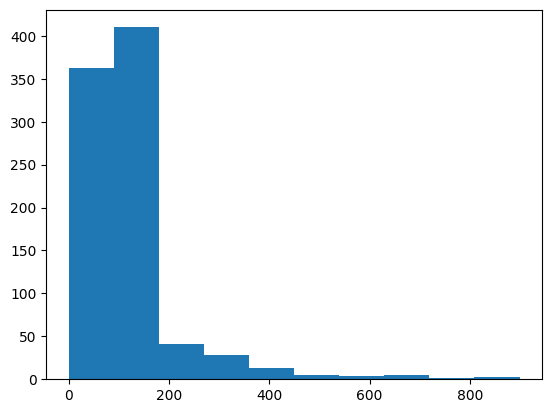

In [52]:
plt.hist(engagement_summary['avg_time_between_engagements'])

#### 4. Intent File
**Intent File**: Includes categories of affiliate sites visited by the account and the date of the action, with a categorized bucket for the type of affiliate site interest.



In [53]:
data_intent = pd.read_excel('../../../data/DS_Homework_-_Intent.xlsx', parse_dates=['date_researched'], header=1, index_col=0)
data_intent

,date_researched,Bucket
id_number,,
154,2022-08-30,Industrial
1844,2023-09-09,Industrial
1922,2023-11-15,Industrial
2729,2021-05-19,Industrial
726,2022-08-23,Industrial
...,...,...
1766,2022-11-30,Procurement
907,2021-03-16,Procurement
374,2024-02-21,Procurement


In [54]:
import pandas as pd

# Load your intent data into a pandas DataFrame from an Excel file
# data_intent = pd.read_excel('/mnt/data/your_data_intent.xlsx', parse_dates=['date_researched'])

# Ensure the data is sorted by company and date
data_intent = data_intent.sort_values(by=['id_number', 'date_researched'])

# Create a count column for intents
data_intent['intent_count'] = 1

# Create lag features
lags = [1, 2, 5, 7]
for lag in lags:
    data_intent[f'intent_count_lag_{lag}'] = data_intent.groupby('id_number')['intent_count'].shift(lag)

# Create rolling averages
rolling_window = 7
data_intent['intent_count_rolling_avg_7'] = data_intent.groupby('id_number')['intent_count'].rolling(window=rolling_window).mean().reset_index(level=0, drop=True)

# Time-Based Features
data_intent['intent_year'] = data_intent['date_researched'].dt.year
data_intent['intent_month'] = data_intent['date_researched'].dt.month
data_intent['intent_day'] = data_intent['date_researched'].dt.day
data_intent['intent_dayofweek'] = data_intent['date_researched'].dt.dayofweek
data_intent['intent_hour'] = data_intent['date_researched'].dt.hour

# Interaction Rate Features
data_intent['weekly_intent_rate'] = data_intent.groupby('id_number')['intent_count'].rolling(window=7).sum().reset_index(level=0, drop=True) / 7

# Previous Bucket
data_intent['previous_bucket'] = data_intent.groupby('id_number')['Bucket'].shift(1)

# Cumulative Counts
data_intent['cumulative_intent_count'] = data_intent.groupby('id_number')['intent_count'].cumsum()

# Days Since Last Intent
data_intent['days_since_last_intent'] = data_intent.groupby('id_number')['date_researched'].diff().dt.days

# Rolling Window Statistics
data_intent['rolling_std_7'] = data_intent.groupby('id_number')['intent_count'].rolling(window=7).std().reset_index(level=0, drop=True)
data_intent['rolling_median_7'] = data_intent.groupby('id_number')['intent_count'].rolling(window=7).median().reset_index(level=0, drop=True)

# Calculate the average time between intents for each id_number
data_intent['time_between_intents'] = data_intent.groupby('id_number')['date_researched'].diff().dt.days
avg_time_between_intents = data_intent.groupby('id_number')['time_between_intents'].mean().reset_index()

# Fill NaN values in avg_time_between_intents with the overall average
avg_time_between_intents['time_between_intents'].fillna(avg_time_between_intents['time_between_intents'].mean(), inplace=True)

# Handle remaining missing values (fill with zero or any other method)
data_intent.fillna(0, inplace=True)

# Group by id_number and aggregate the required columns
intent_summary = data_intent.groupby('id_number').agg(
    total_intents=('intent_count', 'sum'),
    first_intent_date=('date_researched', 'min'),
    last_intent_date=('date_researched', 'max'),
    most_common_intent=('Bucket', lambda x: x.mode()[0])  # Calculate the most common intent type
).reset_index()

# Calculate the intent length in days
intent_summary['intent_length_days'] = (intent_summary['last_intent_date'] - intent_summary['first_intent_date']).dt.days

# Aggregate lag features and rolling averages
lag_columns = [f'intent_count_lag_{lag}' for lag in lags]
rolling_columns = ['intent_count_rolling_avg_7', 'rolling_std_7', 'rolling_median_7']
additional_columns = ['intent_year', 'intent_month', 'intent_day', 'intent_dayofweek', 'intent_hour', 'weekly_intent_rate', 
                      'previous_bucket', 'cumulative_intent_count', 'days_since_last_intent']

# Exclude non-numeric columns for aggregation
numeric_columns = lag_columns + rolling_columns + ['weekly_intent_rate', 'cumulative_intent_count', 'days_since_last_intent']

# Aggregate these features by taking their mean (or sum, or any other relevant aggregation)
lag_agg = data_intent.groupby('id_number')[numeric_columns].mean().reset_index()

# One-hot encode the previous_bucket
previous_bucket_dummies = pd.get_dummies(data_intent['previous_bucket'], prefix='prev_bucket')

# Convert boolean dummies to integers (0 or 1)
previous_bucket_dummies = previous_bucket_dummies.astype(int)

# Concatenate the one-hot encoded columns back to the original dataframe
data_intent = pd.concat([data_intent, previous_bucket_dummies], axis=1)

# Aggregate the one-hot encoded columns
dummy_columns = previous_bucket_dummies.columns
dummy_agg = data_intent.groupby('id_number')[dummy_columns].max().reset_index()

# Merge the aggregated numeric features and one-hot encoded columns into intent_summary
intent_summary = intent_summary.merge(lag_agg, on='id_number', how='left')
intent_summary = intent_summary.merge(dummy_agg, on='id_number', how='left')

# Merge the average time between intents into intent_summary
intent_summary = intent_summary.merge(avg_time_between_intents.rename(columns={'time_between_intents': 'avg_time_between_intents'}), on='id_number', how='left')

# One-hot encode the most_common_intent
most_common_intent_dummies = pd.get_dummies(intent_summary['most_common_intent'], prefix='most_common_intent')

# Convert boolean dummies to integers (0 or 1)
most_common_intent_dummies = most_common_intent_dummies.astype(int)

# Concatenate the one-hot encoded columns back to the intent_summary dataframe
intent_summary = pd.concat([intent_summary, most_common_intent_dummies], axis=1)

# Drop the original most_common_intent column as it's now one-hot encoded
intent_summary.drop(columns=['most_common_intent'], inplace=True)

# Display the resulting DataFrame
intent_summary


C:\Users\Caleb\AppData\Local\Temp\ipykernel_30160\1552763251.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  avg_time_between_intents['time_between_intents'].fillna(avg_time_between_intents['time_between_intents'].mean(), inplace=True)


,id_number,total_intents,first_intent_date,last_intent_date,intent_length_days,intent_count_lag_1,intent_count_lag_2,intent_count_lag_5,intent_count_lag_7,intent_count_rolling_avg_7,...,prev_bucket_Safety,prev_bucket_Telematics,avg_time_between_intents,most_common_intent_Brand,most_common_intent_Competitor,most_common_intent_Compliance,most_common_intent_Industrial,most_common_intent_Procurement,most_common_intent_Safety,most_common_intent_Telematics
0,3,3,2022-05-19,2022-10-25,159,0.666667,0.333333,0.000000,0.000000,0.000000,...,1,0,79.500000,0,0,0,0,0,1,0
1,6,1,2023-05-09,2023-05-09,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,101.445634,0,0,0,0,1,0,0
2,9,1,2023-01-15,2023-01-15,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,101.445634,0,0,0,0,0,1,0
3,19,541,2021-02-01,2024-03-01,1124,0.998152,0.996303,0.990758,0.987061,0.988909,...,1,1,2.081481,0,0,0,0,1,0,0
4,21,1,2023-11-26,2023-11-26,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,101.445634,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,3011,16,2021-10-12,2024-02-15,856,0.937500,0.875000,0.687500,0.562500,0.625000,...,1,0,57.066667,0,0,0,0,0,1,0
1110,3015,1,2021-11-24,2021-11-24,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,101.445634,0,0,0,0,1,0,0
1111,3022,3,2021-12-13,2024-02-05,784,0.666667,0.333333,0.000000,0.000000,0.000000,...,0,0,392.000000,0,0,0,0,1,0,0
1112,3023,1,2021-08-06,2021-08-06,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,101.445634,0,0,0,0,1,0,0


(array([624., 362.,  67.,  28.,  11.,  11.,   5.,   2.,   1.,   3.]),
 array([2.65306122e-01, 9.99387755e+01, 1.99612245e+02, 2.99285714e+02,
        3.98959184e+02, 4.98632653e+02, 5.98306122e+02, 6.97979592e+02,
        7.97653061e+02, 8.97326531e+02, 9.97000000e+02]),
 <BarContainer object of 10 artists>)

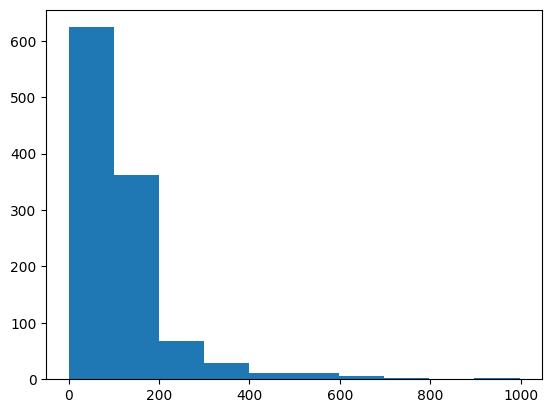

In [55]:
plt.hist(intent_summary['avg_time_between_intents'])

#### 5. Met Target Date File
**Met Target Date File**: A list of Accounts that met the target (i.e. reached participated in a trial with our company), and the date the target was met.


In [56]:
data = load_excel_data(datasets[4])
data

,target_met_date
id_number,
33,2018-12-20 18:24:44.000000 UTC
283,2022-08-25 16:44:57.000000 UTC
31,2017-12-23 16:26:50.000000 UTC
249,2021-09-10 14:08:53.000000 UTC
205,2020-07-07 12:45:38.000000 UTC
...,...
79,2018-08-08 18:42:13.000000 UTC
270,2022-12-09 21:52:58.000000 UTC
230,2020-06-08 22:52:36.000000 UTC


In [57]:
# Print number of unique companies
num_companies = data.index.nunique()
print(f"The dataset contains {num_companies} unique companies.")

The dataset contains 316 unique companies.


#### 6. Third Party Readiness Score File
**Third Party Readiness Score File**: Includes an account readiness score acquired via a third party data provider.


In [58]:
data = load_excel_data(datasets[5])
data

,D&B_Score
id_number,
2,MEDIUM
5,HIGH
6,HIGH
9,HIGH
15,HIGH
...,...
3011,HIGH
3014,HIGH
3023,HIGH


In [59]:
# Print number of unique companies
num_companies = data.index.nunique()
print(f"The dataset contains {num_companies} unique companies.")

The dataset contains 873 unique companies.


## Let's put this data together!

In [60]:
# Merge all summarized data with the raw datasets on 'id_number'
merged_data = data_accounts.merge(email_summary, on='id_number', how='outer')\
                           .merge(engagement_summary, on='id_number', how='outer')\
                           .merge(intent_summary, on='id_number', how='outer')\
                           .merge(data_target_met, on='id_number', how='outer')\
                           .merge(data_third_party, on='id_number', how='outer')

# For all companies
merged_data.head()

,id_number,org_size_1_99,org_size_100_499,org_size_500_999,org_size_1000_4999,org_size_greaterthan_5000,Post_Sale_Outreach,Has_Website,PreviousCompetitorCustomer,Number_of_Vehicles__c,...,avg_time_between_intents,most_common_intent_Brand,most_common_intent_Competitor,most_common_intent_Compliance,most_common_intent_Industrial,most_common_intent_Procurement,most_common_intent_Safety,most_common_intent_Telematics,target_met_date,D&B_Score
0,1,1,0,0,0,0,1,0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-23 21:46:58.000000 UTC,NaN
1,2,1,0,0,0,0,1,0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-03 14:21:14.000000 UTC,MEDIUM
2,3,1,0,0,0,0,1,0,NaN,2.0,...,79.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2019-10-17 16:30:59.000000 UTC,NaN
3,4,1,0,0,0,0,1,0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-11 14:01:52.000000 UTC,NaN
4,5,1,0,0,0,0,1,0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-30 20:04:23.000000 UTC,HIGH


### Training Dataset

In [61]:
# Create dataset for companies present in EmailAction summary
companies_in_email_action = email_summary['id_number'].unique()
data_in_email_action = merged_data[merged_data['id_number'].isin(companies_in_email_action)].copy()

# Add 'target_met' column
data_in_email_action['target_met'] = data_in_email_action['target_met_date'].notnull().astype(int)

In [62]:
# data_in_email_action.isna().sum()

### PreviousCompetitorCustomer
 Because of the sheer amount of missing data, I will take the freedom to ignore this column, see 1-eda.
 

In [63]:
train = data_in_email_action.drop('PreviousCompetitorCustomer', axis=1) 

In [64]:
train.isna().sum()

id_number                          0
org_size_1_99                      0
org_size_100_499                   0
org_size_500_999                   0
org_size_1000_4999                 0
                                ... 
most_common_intent_Safety        208
most_common_intent_Telematics    208
target_met_date                  340
D&B_Score                        178
target_met                         0
Length: 108, dtype: int64

#### Because of perfect collinearity, we have to drop the variable 'Post_Sale_Outreach'

In [65]:
(train['target_met'] == train['Post_Sale_Outreach']).sum()

565

In [66]:
# train.drop('Post_Sale_Outreach', axis=1, inplace=True)
# test.drop('Post_Sale_Outreach', axis=1, inplace=True)

### Why do we have all this missing data in our training dataset?

Well...

All target_met companies are in EmailAction summary: False
All target_met companies are in Engagement summary: False
All target_met companies are in Intent summary: False
Number of target_met companies not in EmailAction summary: 91
IDs not in EmailAction summary: [1, 2, 3, 4, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 21, 22, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 42, 43, 45, 46, 47, 48, 49, 51, 52, 55, 61, 63, 64, 68, 74, 75, 78, 79, 80, 89, 93, 96, 97, 98, 107, 109, 126, 131, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 168, 172, 182, 189, 190, 224, 231, 244, 273, 275, 278, 289, 290, 305, 818]
Number of target_met companies not in Engagement summary: 81
IDs not in Engagement summary: [1, 3, 4, 7, 8, 10, 11, 12, 13, 14, 17, 18, 21, 22, 23, 26, 30, 31, 32, 33, 34, 35, 36, 38, 41, 43, 45, 46, 47, 48, 49, 51, 52, 55, 62, 64, 66, 67, 68, 70, 75, 78, 79, 80, 81, 93, 94, 101, 107, 109, 123, 128, 138, 139, 140, 141, 143, 144, 145, 146,

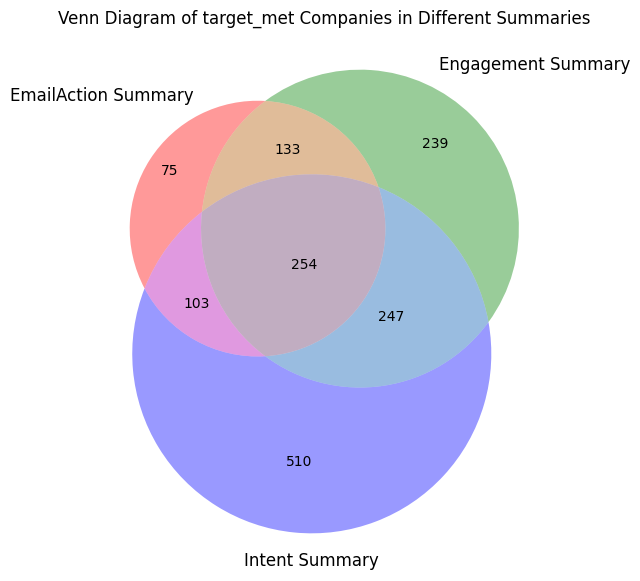

In [67]:
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Assuming the summary datasets are already loaded and processed

# Extract unique IDs from each summary dataset
email_ids = set(email_summary['id_number'].unique().tolist())
engagement_ids = set(engagement_summary['id_number'].unique().tolist())
intent_ids = set(intent_summary['id_number'].unique().tolist())
target_met_ids = set(data_target_met.index.unique().tolist())

# Check if all target_met companies are in each summary dataset
all_in_email = all(element in email_ids for element in target_met_ids)
all_in_engagement = all(element in engagement_ids for element in target_met_ids)
all_in_intent = all(element in intent_ids for element in target_met_ids)

# Find missing IDs if any
missing_in_email = [element for element in target_met_ids if element not in email_ids]
missing_in_engagement = [element for element in target_met_ids if element not in engagement_ids]
missing_in_intent = [element for element in target_met_ids if element not in intent_ids]

# Print results
print(f"All target_met companies are in EmailAction summary: {all_in_email}")
print(f"All target_met companies are in Engagement summary: {all_in_engagement}")
print(f"All target_met companies are in Intent summary: {all_in_intent}")

# Print missing IDs if any
if not all_in_email:
    print(f"Number of target_met companies not in EmailAction summary: {len(missing_in_email)}")
    print(f"IDs not in EmailAction summary: {missing_in_email}")

if not all_in_engagement:
    print(f"Number of target_met companies not in Engagement summary: {len(missing_in_engagement)}")
    print(f"IDs not in Engagement summary: {missing_in_engagement}")

if not all_in_intent:
    print(f"Number of target_met companies not in Intent summary: {len(missing_in_intent)}")
    print(f"IDs not in Intent summary: {missing_in_intent}")

# Create Venn diagram
plt.figure(figsize=(10, 7))
venn = venn3(
    subsets=(email_ids, engagement_ids, intent_ids),
    set_labels=('EmailAction Summary', 'Engagement Summary', 'Intent Summary')
)

# Add a title
plt.title('Venn Diagram of target_met Companies in Different Summaries')

# Display the plot
plt.show()


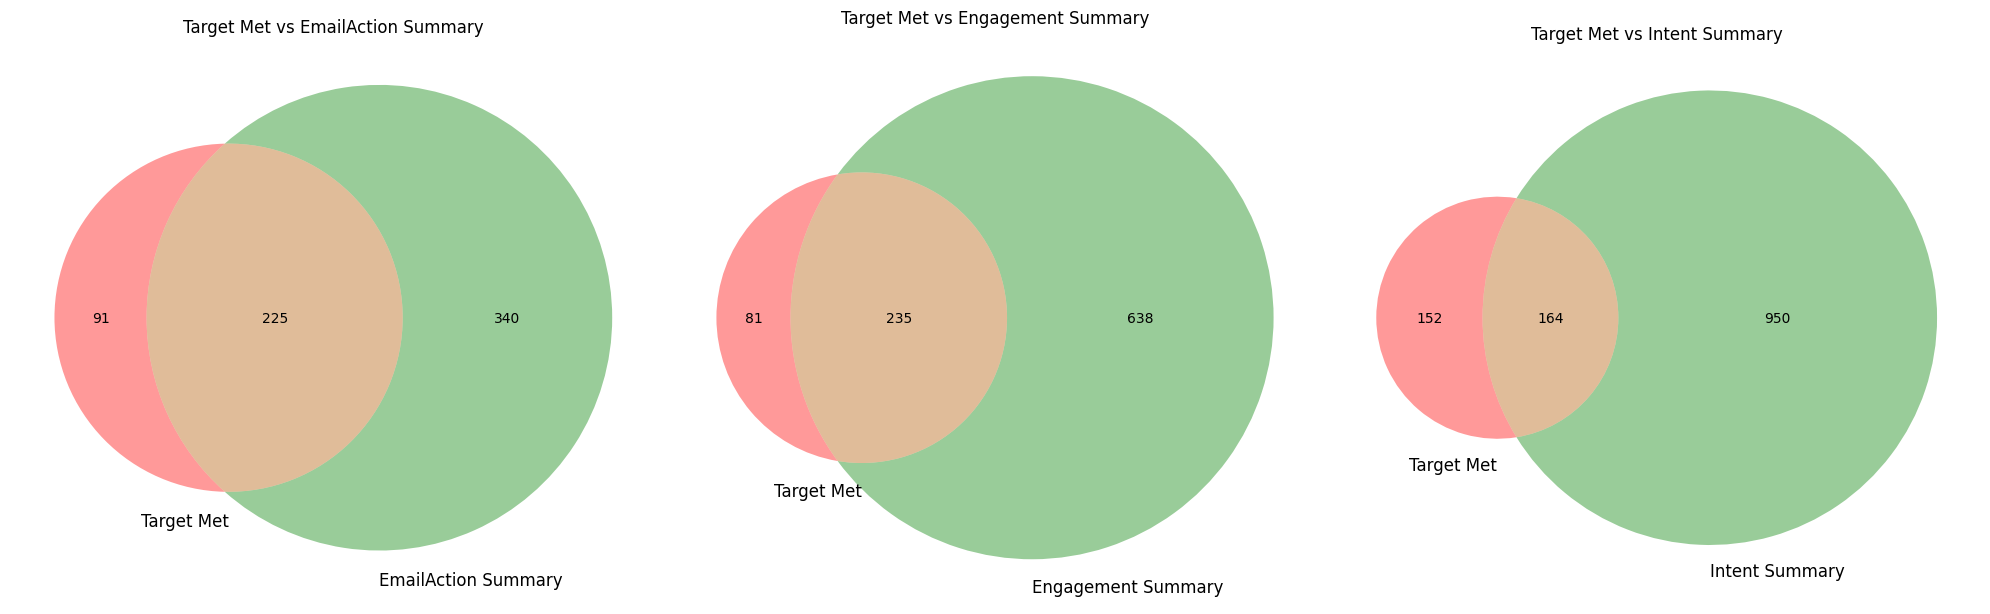

In [68]:
import pandas as pd
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt

# Assuming the summary datasets are already loaded and processed

# Extract unique IDs from each summary dataset
email_ids = set(email_summary['id_number'].unique().tolist())
engagement_ids = set(engagement_summary['id_number'].unique().tolist())
intent_ids = set(intent_summary['id_number'].unique().tolist())
target_met_ids = set(data_target_met.index.unique().tolist())

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

# Venn diagram for target_met and EmailAction summary
venn2(
    subsets=(target_met_ids, email_ids),
    set_labels=('Target Met', 'EmailAction Summary'),
    ax=axs[0]
)
axs[0].set_title('Target Met vs EmailAction Summary')

# Venn diagram for target_met and Engagement summary
venn2(
    subsets=(target_met_ids, engagement_ids),
    set_labels=('Target Met', 'Engagement Summary'),
    ax=axs[1]
)
axs[1].set_title('Target Met vs Engagement Summary')

# Venn diagram for target_met and Intent summary
venn2(
    subsets=(target_met_ids, intent_ids),
    set_labels=('Target Met', 'Intent Summary'),
    ax=axs[2]
)
axs[2].set_title('Target Met vs Intent Summary')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


As seen here, **not all companies that have reached a sale have had their intent, engagements and email actions tracked and recorded!**


Here we are at a crossroad with 2 options:
- we either pick a subset of target met vs email or engagement or intent 
- OR we consider only the **subset** of companies for which I have all the data as the companies that met the sales target

**Design Questions**

Now, this leads to a design question: which auxiliary data should we prefer? Email actions, engagements, or intent? We have some tradeoffs and wins:

1.  Email action: 
- Win, we have 225 target met companies for which we tracked email interactions! 
- TradeoffHowever: we have only 340 companies for our remaining data set as our negative target variable. And we will not be considering any other dataset between Engagement and Intent
2. Engagement: 
-  Win, we have 235 tracked target companies! 
- Trade off: we will not be considering any other dataset between Engagement and Intent
3.  Intent: 
-  Win: a larger dataset with 950 non-met target companies! 
- Tradeoff: class imbalace with unfortunately only 164 targets met.


4. Subset of all:
- Win: we can consider all datasets!
- Tradeoff: very small dataset with only about 200~ observations



#### Train

In [69]:
import pandas as pd


# Columns to impute
columns_to_impute = ['Number_of_Vehicles__c', 'Industry', 'D&B_Score']

# Function to impute missing values
def impute_missing_values(df, columns):
    for column in columns:
        if df[column].dtype == 'object':
            # For categorical data, impute with the most frequent value (mode)
            mode_value = df[column].mode()[0]
            df[column].fillna(mode_value, inplace=True)
        else:
            # For numerical data, impute with the mean
            mean_value = round(df[column].mean())
            df[column].fillna(mean_value, inplace=True)
    return df


# Load the datasets
data_accounts = load_excel_data(datasets[0])
# email_summary = load_excel_data(datasets[1])
# engagement_summary = load_excel_data(datasets[2])
# intent_summary = load_excel_data(datasets[3])
data_target_met = load_excel_data(datasets[4])
data_third_party = load_excel_data(datasets[5])

# Reset index to make 'id_number' a column in data_accounts
data_accounts = data_accounts.reset_index()
data_target_met = data_target_met.reset_index()

# Extract unique IDs from target_met dataset
target_met_ids = set(data_target_met['id_number'].unique().tolist())

# Merge as necessary for EmailAction Summary
email_merged_data = data_accounts.merge(email_summary, on='id_number', how='inner')
email_merged_data = email_merged_data.merge(data_target_met, on='id_number', how='left')
email_merged_data = email_merged_data.merge(data_third_party, on='id_number', how='left')
email_merged_data['target_met'] = email_merged_data['id_number'].isin(target_met_ids).astype(int)
email_merged_data = email_merged_data.drop(['PreviousCompetitorCustomer', 'target_met_date'], axis=1) 
email_merged_data = impute_missing_values(email_merged_data, columns_to_impute)
email_merged_data.drop('Post_Sale_Outreach', axis=1, inplace=True)


# Merge as necessary for Engagement Summary
engagement_merged_data = data_accounts.merge(engagement_summary, on='id_number', how='inner')
engagement_merged_data = engagement_merged_data.merge(data_target_met, on='id_number', how='left')
engagement_merged_data = engagement_merged_data.merge(data_third_party, on='id_number', how='left')
engagement_merged_data['target_met'] = engagement_merged_data['id_number'].isin(target_met_ids).astype(int)
engagement_merged_data = engagement_merged_data.drop(['PreviousCompetitorCustomer', 'target_met_date'], axis=1) 
engagement_merged_data = impute_missing_values(engagement_merged_data, columns_to_impute)
engagement_merged_data.drop('Post_Sale_Outreach', axis=1, inplace=True)

# Merge as necessary for Intent Summary
intent_merged_data = data_accounts.merge(intent_summary, on='id_number', how='inner')
intent_merged_data = intent_merged_data.merge(data_target_met, on='id_number', how='left')
intent_merged_data = intent_merged_data.merge(data_third_party, on='id_number', how='left')
intent_merged_data['target_met'] = intent_merged_data['id_number'].isin(target_met_ids).astype(int)
intent_merged_data = intent_merged_data.drop(['PreviousCompetitorCustomer', 'target_met_date'], axis=1) 
intent_merged_data = impute_missing_values(intent_merged_data, columns_to_impute)
intent_merged_data.drop('Post_Sale_Outreach', axis=1, inplace=True)

# Find the intersection of id_numbers across email, engagement, and intent summaries
intersection_ids = set(email_summary['id_number']).intersection(engagement_summary['id_number'], intent_summary['id_number'])

# Merge as necessary for Intersection Summary
intersection_merged_data = data_accounts[data_accounts['id_number'].isin(intersection_ids)]
intersection_merged_data = intersection_merged_data.merge(engagement_summary, on='id_number', how='inner')
intersection_merged_data = intersection_merged_data.merge(email_summary, on='id_number', how='inner')
intersection_merged_data = intersection_merged_data.merge(intent_summary, on='id_number', how='inner')
intersection_merged_data = intersection_merged_data.merge(data_target_met, on='id_number', how='left')
intersection_merged_data = intersection_merged_data.merge(data_third_party, on='id_number', how='left')
intersection_merged_data['target_met'] = intersection_merged_data['id_number'].isin(target_met_ids).astype(int)
intersection_merged_data = intersection_merged_data.drop(['PreviousCompetitorCustomer', 'target_met_date'], axis=1) 
intersection_merged_data = impute_missing_values(intersection_merged_data, columns_to_impute)
intersection_merged_data.drop('Post_Sale_Outreach', axis=1, inplace=True)


C:\Users\Caleb\AppData\Local\Temp\ipykernel_30160\2849772674.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mean_value, inplace=True)
C:\Users\Caleb\AppData\Local\Temp\ipykernel_30160\2849772674.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [70]:

# Print the shapes of each dataset
print("Shapes of the datasets:")
print(f"EmailAction Summary based dataset: {email_merged_data.shape}")
print(f"Engagement Summary based dataset: {engagement_merged_data.shape}")
print(f"Intent Summary based dataset: {intent_merged_data.shape}")
print(f"Intersection Summary based dataset: {intersection_merged_data.shape}")

Shapes of the datasets:
EmailAction Summary based dataset: (565, 37)
Engagement Summary based dataset: (873, 57)
Intent Summary based dataset: (1114, 48)
Intersection Summary based dataset: (254, 106)


In [71]:
# Saving the datasets to the specified directories
email_merged_data.to_csv('../../../data_processed/email/train.csv', index=False)
engagement_merged_data.to_csv('../../../data_processed/engagement/train.csv', index=False)
intent_merged_data.to_csv('../../../data_processed/intent/train.csv', index=False)
intersection_merged_data.to_csv('../../../data_processed/intersection/train.csv', index=False)


In [72]:
# Create test datasets
def create_test_data():
    # Filter out companies that are in the target_met dataset
    non_target_met_ids = data_accounts[~data_accounts['id_number'].isin(target_met_ids)]['id_number'].unique()
    print(len(non_target_met_ids
              ))
    # Merge as necessary for EmailAction Summary
    email_test_data = data_accounts[data_accounts['id_number'].isin(non_target_met_ids)].merge(email_summary, on='id_number', how='inner')
    email_test_data = email_test_data.merge(data_third_party, on='id_number', how='left')
    email_test_data = email_test_data.drop(['PreviousCompetitorCustomer'], axis=1) 
    email_test_data = impute_missing_values(email_test_data, columns_to_impute)
    email_test_data.drop('Post_Sale_Outreach', axis=1, inplace=True)

    email_test_data.to_csv('../../../data_processed/email/test.csv', index=False)

    # Merge as necessary for Engagement Summary
    engagement_test_data = data_accounts[data_accounts['id_number'].isin(non_target_met_ids)].merge(engagement_summary, on='id_number', how='inner')
    engagement_test_data = engagement_test_data.merge(data_third_party, on='id_number', how='left')
    engagement_test_data = engagement_test_data.drop(['PreviousCompetitorCustomer'], axis=1) 
    engagement_test_data = impute_missing_values(engagement_test_data, columns_to_impute)
    engagement_test_data.drop('Post_Sale_Outreach', axis=1, inplace=True)

    engagement_test_data.to_csv('../../../data_processed/engagement/test.csv', index=False)

    # Merge as necessary for Intent Summary
    intent_test_data = data_accounts[data_accounts['id_number'].isin(non_target_met_ids)].merge(intent_summary, on='id_number', how='inner')
    intent_test_data = intent_test_data.merge(data_third_party, on='id_number', how='left')
    intent_test_data = intent_test_data.drop(['PreviousCompetitorCustomer'], axis=1) 
    intent_test_data = impute_missing_values(intent_test_data, columns_to_impute)
    intent_test_data.drop('Post_Sale_Outreach', axis=1, inplace=True)

    intent_test_data.to_csv('../../../data_processed/intent/test.csv', index=False)

    # Find the intersection of id_numbers across email, engagement, and intent summaries
    intersection_test_ids = set(email_summary['id_number']).intersection(engagement_summary['id_number'], intent_summary['id_number']).difference(target_met_ids)

    # Merge as necessary for Intersection Summary
    intersection_test_data = data_accounts[data_accounts['id_number'].isin(intersection_test_ids)]
    intersection_test_data = intersection_test_data.merge(engagement_summary, on='id_number', how='inner')
    intersection_test_data = intersection_test_data.merge(email_summary, on='id_number', how='inner')
    intersection_test_data = intersection_test_data.merge(intent_summary, on='id_number', how='inner')
    intersection_test_data = intersection_test_data.merge(data_third_party, on='id_number', how='left')
    intersection_test_data = intersection_test_data.drop(['PreviousCompetitorCustomer'], axis=1) 
    intersection_test_data = impute_missing_values(intersection_test_data, columns_to_impute)
    intersection_test_data.drop('Post_Sale_Outreach', axis=1, inplace=True)

    intersection_test_data.to_csv('../../../data_processed/intersection/test.csv', index=False)

    
    # Print the shapes of each dataset
    print("Shapes of the datasets:")
    print(f"EmailAction Summary based dataset: {email_test_data.shape}")
    # print(email_test_data.isna().sum())
    print(f"Engagement Summary based dataset: {engagement_test_data.shape}")
    # print(engagement_test_data.isna().sum())

    print(f"Intent Summary based dataset: {intent_test_data.shape}")
    # print(intent_test_data.isna().sum())

    print(f"Intersection Summary based dataset: {intersection_test_data.shape}")
    # print(intersection_test_data.isna().sum())


create_test_data()

2712
Shapes of the datasets:
EmailAction Summary based dataset: (340, 36)
Engagement Summary based dataset: (638, 56)
Intent Summary based dataset: (950, 47)
Intersection Summary based dataset: (132, 105)


C:\Users\Caleb\AppData\Local\Temp\ipykernel_30160\2849772674.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mean_value, inplace=True)
C:\Users\Caleb\AppData\Local\Temp\ipykernel_30160\2849772674.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

**End of Notebook**